In [1]:
%%capture

# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
# jax on M1: https://github.com/google/jax/issues/5501

# relative imports
import os
os.chdir('/Users/martinmarek/Google Drive/STAT35/bnn-regression')
import models, training, distributions

In [2]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# TODO:
# key, _ = jax.random.split(key)
# vs.
# _, key = jax.random.split(key)
# vs.
# key = jax.random.split(key, 1)[1]

## generate synthetic regression data

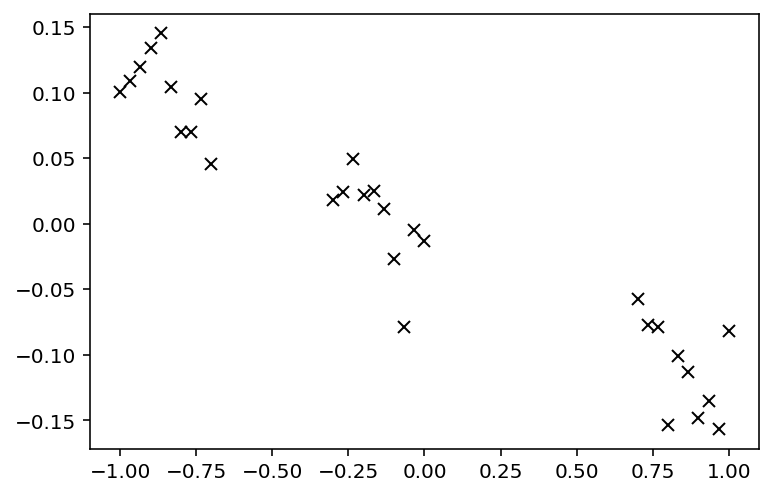

In [5]:
# observed x
x_train = jnp.concatenate([jnp.linspace(s, s+0.3, 10) for s in [-1, -0.3, 0.7]])
x_train = x_train[:, None]
N, C = x_train.shape

# true model
sigma_obs = 0.03
key = jax.random.PRNGKey(0)
w = 0.5 * jax.random.normal(key, [C])
y_train = jnp.dot(x_train, w) + jnp.power(0.2 * x_train[:, 1], 2.0) * jnp.sin(4.0 * x_train[:, 1])

# add noise
key, _ = jax.random.split(key)
y_train += sigma_obs * jax.random.normal(key, [N])

# plot dataset
plt.plot(x_train[:, 0], y_train, 'kx')
plt.show()

## define model

In [6]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
predict_fn, params_init = models.make_nn(x_train, 3*[100])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(10)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [7]:
# TEST: NN params shape
print(jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print(log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

FlatMap({
  'linear': FlatMap({'b': (100,), 'w': (1, 100)}),
  'linear_1': FlatMap({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMap({'b': (100,), 'w': (100, 100)}),
  'linear_3': FlatMap({'b': (2,), 'w': (100, 2)}),
})
-66370.97 -21.08315 -66392.055


## RWMH

In [8]:
%%time
# TODO: why is the acceptance_rate so low dispite such small steps?
key = jax.random.PRNGKey(0)
n_steps = 10
n_blind_steps = 10_000
step_size = 1e-3
params_rwmh = training.rwmh_sampler(params_init, log_posterior_fn, key, n_steps, n_blind_steps, step_size)

Avg. accept. prob.: 23.00%
CPU times: user 57 s, sys: 25 s, total: 1min 22s
Wall time: 35.8 s


## HMC

In [9]:
%%time
n_steps = 20
step_size = 1e-5
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
params_hmc = training.hmc_sampler(params_init, log_posterior_fn, n_steps, n_leapfrog_steps, step_size, key)

Avg. accept. prob.: 78.02%
CPU times: user 35.4 s, sys: 151 ms, total: 35.6 s
Wall time: 35.6 s


## SGD

In [10]:
%%time
# TODO: deep ensambles
params_sgd, log_prob_sgd = training.train_sgd(params_init, log_likelihood_fn, n_epochs=20_000, lr=1e-5, m=0)

CPU times: user 2.14 s, sys: 13.1 ms, total: 2.15 s
Wall time: 2.15 s


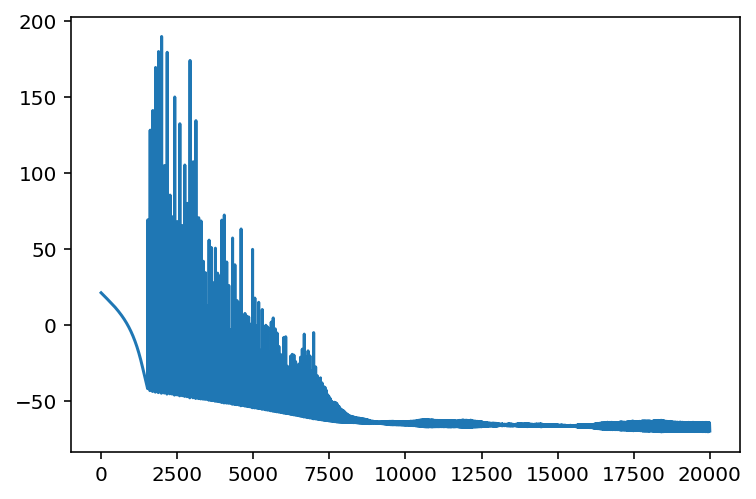

In [11]:
plt.plot(log_prob_sgd)

## plot predictions

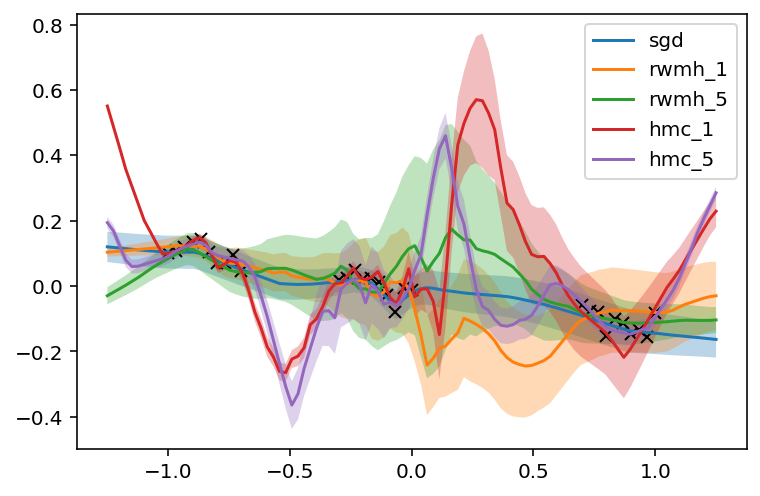

In [17]:
fig, ax = plt.subplots()

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')


# labeled results
labeled_params = {
    'sgd': params_sgd,
    'rwmh_1': params_rwmh[-1],
    'rwmh_5': params_rwmh[-5],
    'hmc_1': params_hmc[-1],
    'hmc_5': params_hmc[-5],
}

# plot predictions
x_full = jnp.linspace(-1.25, 1.25, 100)[:, None]
for label, params in labeled_params.items():
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=label)

ax.legend(loc='upper right')
plt.show()

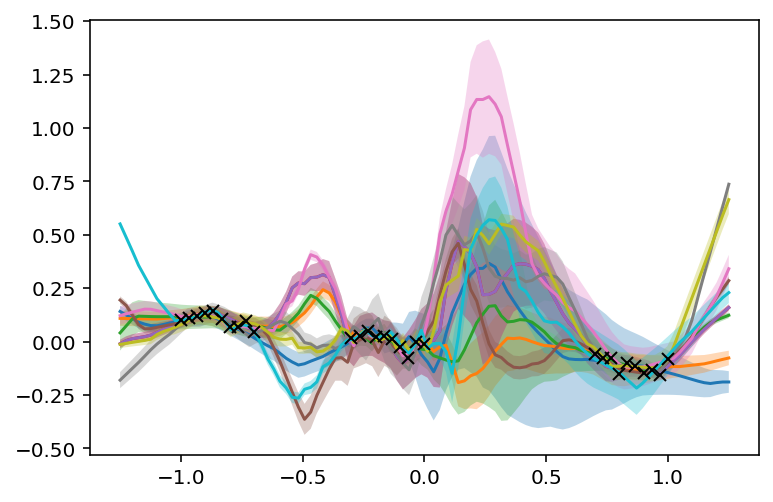

In [13]:
fig, ax = plt.subplots()

# plot predictions
x_full = jnp.linspace(-1.25, 1.25, 100)[:, None]
for params in params_hmc[10:]:
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0])

# plot training data
ax.plot(x_train[:, 0], y_train, 'kx')

plt.show()

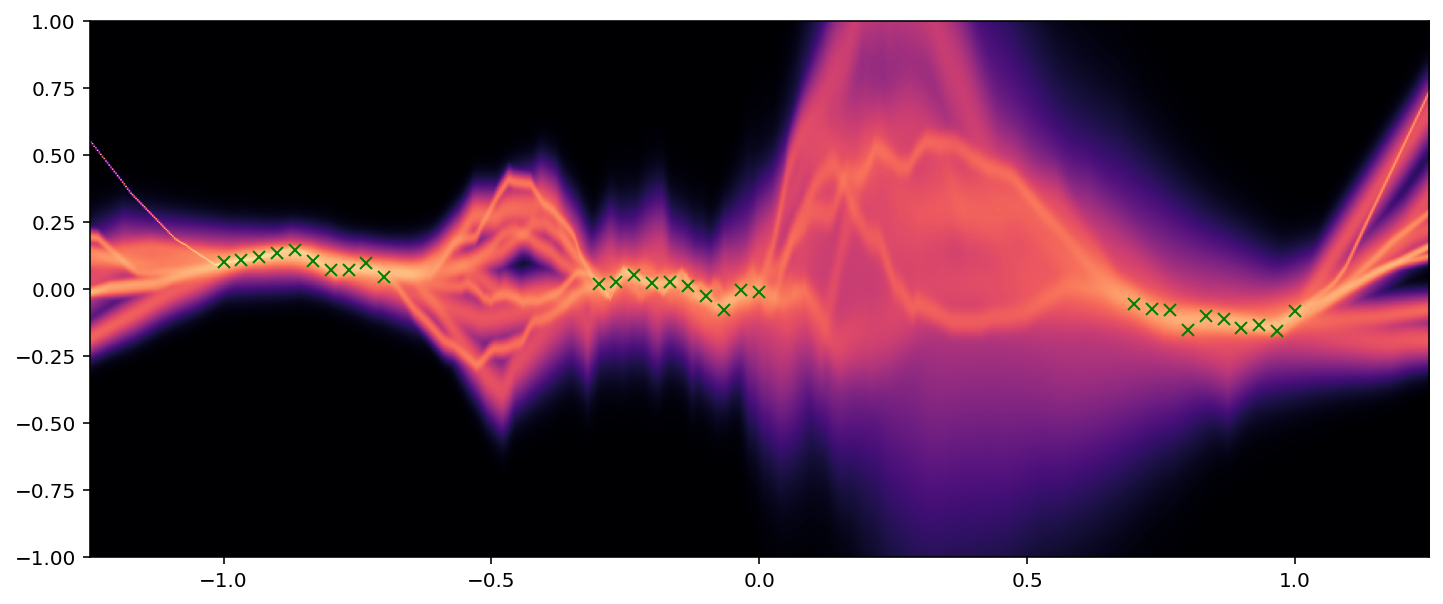

In [14]:
# create grid to evaluate posterior predictive density
nx, ny = 800, 400
x_full = jnp.linspace(-1.25, 1.25, nx)
y_full = jnp.linspace(-1, 1, ny)
z_full = jnp.zeros([nx, ny])

# average over posterior samples
warmup_steps = 10
used_steps = len(params_hmc) - warmup_steps
for params in params_hmc[warmup_steps:]:
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
    z_full += jnp.exp(log_prob) / used_steps

# density plot
fig, ax = plt.subplots(figsize=[12, 8])
extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
ax.imshow(z_full.T**(1/8), origin='lower', cmap='magma', extent=extent, aspect=1/2)
ax.plot(x_train[:, 0], y_train, 'x', color='green')
plt.show()

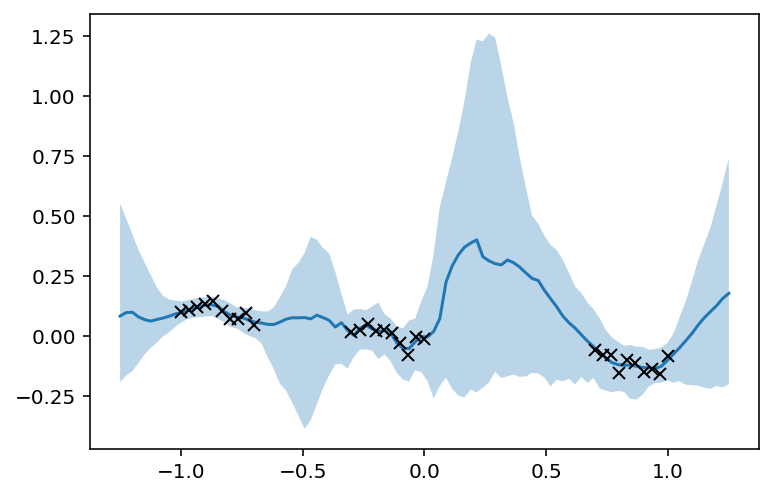

In [15]:
key = jax.random.PRNGKey(0)
alpha = 0.05
warmup_steps = 10
used_steps = len(params_hmc) - warmup_steps
nx = 100
x_full = jnp.linspace(-1.25, 1.25, nx)
n_samples = 1_000
n_samples_per_step = n_samples // used_steps

samples = jnp.zeros([nx, used_steps, n_samples_per_step])
for i, params in enumerate(params_hmc[warmup_steps:]):
    key, _ = jax.random.split(key)
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
    samples = samples.at[:, i, :].set(current_samples)

# flatten sampled predictions across posterior samples
samples = samples.reshape([nx, used_steps*n_samples_per_step])

# get posterior predictive quntiles
quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    
# CI plot
fig, ax = plt.subplots()
ax.fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3)
ax.plot(x_full, quantiles[1, :])
ax.plot(x_train[:, 0], y_train, 'kx')
plt.show()